In [1]:
###############################################################################
import math
import numpy as np
from pathlib import Path
import os
from lmfit import Minimizer, Parameters, report_fit
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import special
import subprocess
import re
###############################################################################

0.3793480717777273

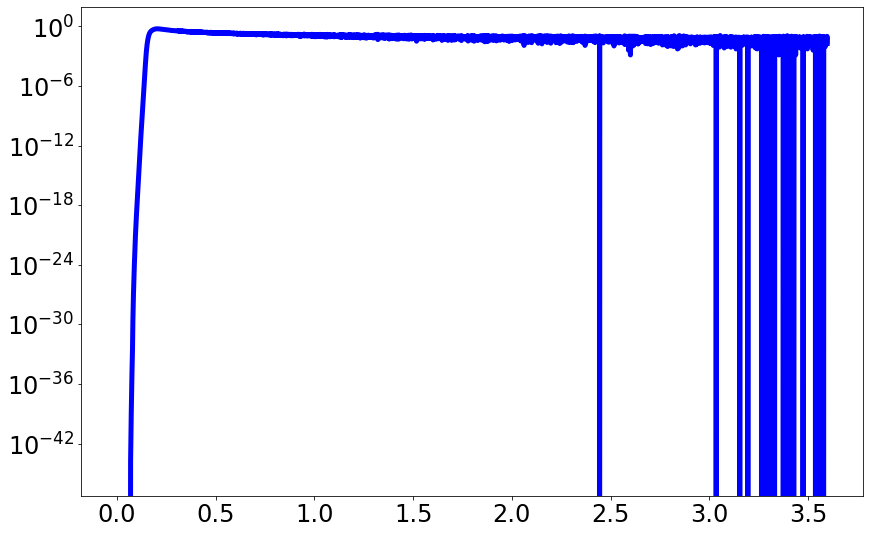

In [48]:
###############################################################################
s = 3 # Smoothness plotting factor: it reads one value every "s"
mvel = []
time = []
conc = []
dCnorm = []
finalIG = []

###############################################################################


###############################################################################

with open("LOGs/logTime") as logTime:
    for line in logTime.readlines():
        time.append(float(line))
with open("LOGs/logFlux") as logFlux:
    for line in logFlux.readlines():
        conc.append(float(line))
with open("LOGs/logVelx") as logVelx:
    for line in logVelx.readlines():
        mvel.append(float(line))

TotT = math.floor(len(time)/30)
        
time = time[0:TotT:s]
conc = conc[0:TotT:s]

Tadv = 2/mvel[0] # If punctual injection Xbox needs to be rested from dd 
ndT = [val/Tadv for j, val in enumerate(time)]
dC = [(conc[j+s]-conc[j])/(ndT[j+s]-ndT[j]) for j, val in enumerate(conc[:-s])] # Smooth derivative
dCnorm = np.array(dC) #.append(np.array(dC)/np.array(sum(dC)))
tt=ndT[:-s+1]
###############################################################################

font = {'size': 24}
plt.rc('font', **font)
plt.figure(figsize=(14, 9))
plt.semilogy(ndT[:-s], dCnorm, lw=5, color='blue')

sum(np.diff(tt)*np.array(dC))

In [49]:
###############################################################################

def InvGau(m,mu,l, t):
    yInvGau = m*(np.sqrt(l/(2*math.pi*t*t*t))*np.exp(-(l*(t-mu)*(t-mu))/(2*mu*mu*t)))
    # yInvGau = m*np.sqrt(l/(2*math.pi*t*t*t))*np.exp(-(l*(t-mu)*(t-mu))/(2*mu*mu*t))/sum(dC)
    # yParInvGau = yParInvGau/sum(yParInvGau)
    return yInvGau[:-s]

def err_InvGau(paramsIG, t, dc):
    l = paramsIG['l']
    mu = paramsIG['mu']
    m = paramsIG['m']
    return InvGau(m,mu,l,t)-dc


# LEAST SQUARES METHOD
paramsIG = Parameters()
paramsIG.add('l', value=1)
paramsIG.add('mu', value=3, max=100)
paramsIG.add('m', value=1)    
# do fit, here with the default leastsq algorithm
minnerIG = Minimizer(err_InvGau, paramsIG, fcn_args=(np.array(ndT), np.array(dCnorm)))
resultIG = minnerIG.minimize()    
# calculate final result
finalIG = dCnorm + np.array(resultIG.residual)  

print(">>> PDF FITTING")
report_fit(resultIG)
mfit = resultIG.params["m"].value
lfit = resultIG.params["l"].value
mufit = resultIG.params["mu"].value


>>> PDF FITTING
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 14482
    # variables        = 3
    chi-square         = 31.6372064
    reduced chi-square = 0.00218504
    Akaike info crit   = -88715.4811
    Bayesian info crit = -88692.7391
[[Variables]]
    l:   0.81200171 +/- 0.00455647 (0.56%) (init = 1)
    mu:  99.9988136 +/- 1048.83168 (1048.84%) (init = 3)
    m:   0.57674589 +/- 0.38621086 (66.96%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, m) = 1.000
    C(l, mu) = -0.677
    C(l, m)  = -0.675


No handles with labels found to put in legend.


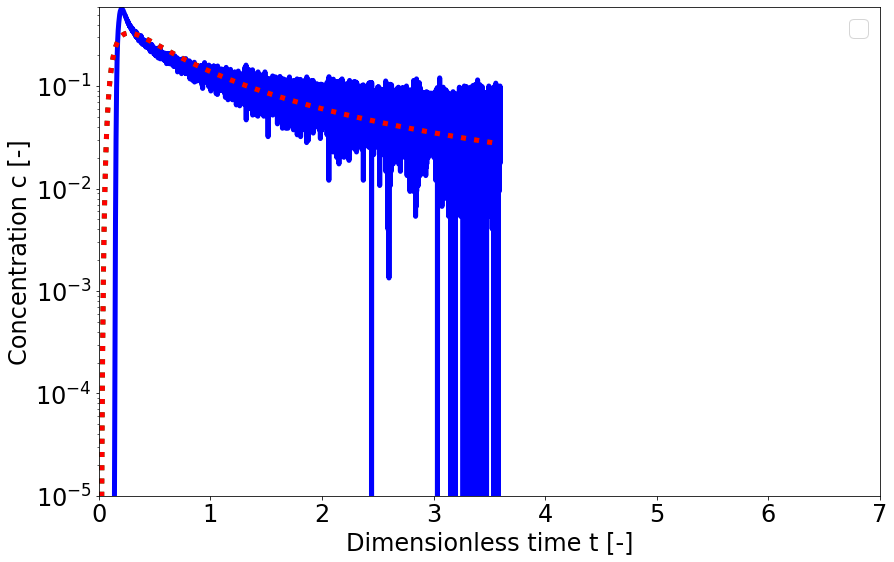

In [50]:
# PLOT SECTION ################################################################
font = {'size': 24}
plt.rc('font', **font)
plt.figure(figsize=(14, 9))
plt.semilogy(ndT[:-s], dCnorm, lw=5, color='blue')
plt.semilogy(ndT[:-s], finalIG, linestyle='dotted', lw=5, color='green')
plt.semilogy(ndT[:-s], InvGau(mfit,mufit,lfit,np.array(ndT)), linestyle='dotted', lw=5, color='red')
plt.xlim([0, 7]) 
plt.ylim([1e-5, 1.05*max(dCnorm)])
plt.xlabel("Dimensionless time t [-]")
plt.ylabel("Concentration c [-]")
plt.legend()